# Cluster

> Enzo Sergiani


## Librairies


In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

## Données


In [56]:
df = pd.read_csv("../../data/exam_data.csv", delimiter=",", decimal=".")

df.describe()

,X,Y
count,800.000000,800.000000
mean,10.809343,4.067838
std,5.360266,3.831002
min,0.000000,-5.029053
25%,6.504486,1.720596
50%,10.716147,4.707356
75%,15.288797,7.161121
max,21.677068,11.232087


Nos données ont pour coordonnées `X` et `Y` de taille 800.


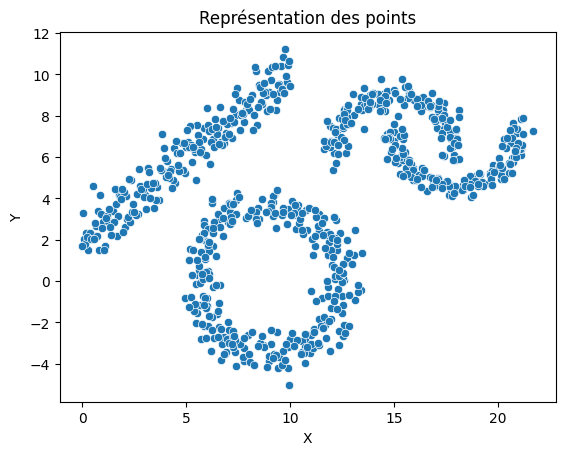

In [57]:
sns.scatterplot(data=df, x="X", y="Y")
plt.title("Représentation des points")
plt.show()

À l'œil nu, on peut constater la présence de 3 clusters. Nous allons utiliser cette valeur comme objectif de clustering et essayer de les prédire.


In [58]:
n_clusters = 3

## K-Means


In [59]:
kmeans = KMeans(n_clusters)
kmeans.fit(df)

df["Cluster"] = kmeans.labels_

df.head()

,X,Y,Cluster
0,6.776043,2.161305,2
1,7.537688,8.778988,2
2,17.667300,6.899375,1
3,17.049413,7.418676,1
4,6.589132,2.978855,2


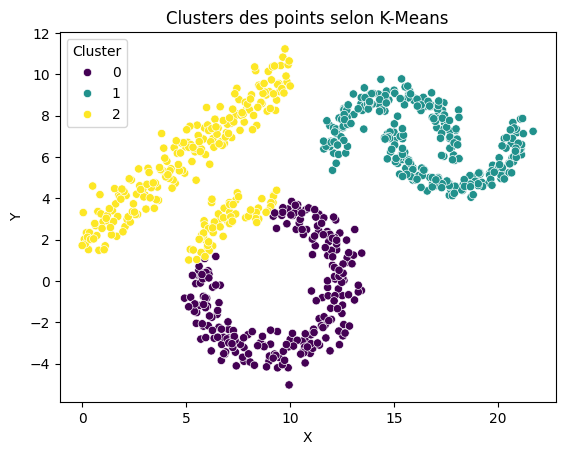

In [60]:
sns.scatterplot(data=df, x="X", y="Y", hue="Cluster", palette="viridis")
plt.title("Clusters des points selon K-Means")
plt.show()

On constate un nombre incorrect de blobs.

## MiniBatch KMeans

In [61]:
mini_batch_kmeans = MiniBatchKMeans(n_clusters)
mini_batch_kmeans.fit(df)

df["Cluster"] = mini_batch_kmeans.labels_

df.head()

,X,Y,Cluster
0,6.776043,2.161305,0
1,7.537688,8.778988,2
2,17.667300,6.899375,1
3,17.049413,7.418676,1
4,6.589132,2.978855,0


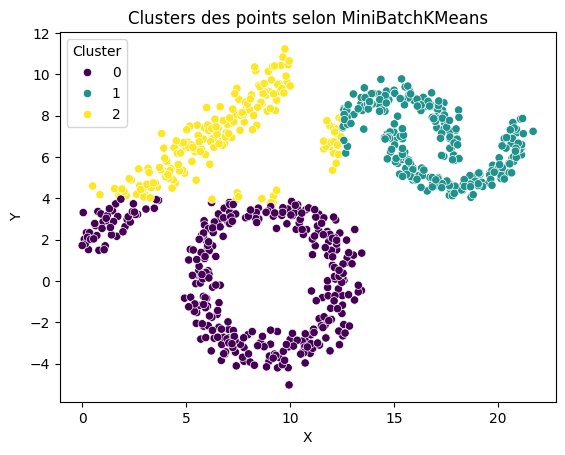

In [62]:
sns.scatterplot(data=df, x="X", y="Y", hue="Cluster", palette="viridis")
plt.title("Clusters des points selon MiniBatchKMeans")
plt.show()

On constate un nombre incorrect de blobs.

## Spectral Clustering


In [63]:
spectral = SpectralClustering(n_clusters)
spectral.fit(df)

df["Cluster"] = spectral.labels_

df.head()

,X,Y,Cluster
0,6.776043,2.161305,2
1,7.537688,8.778988,0
2,17.667300,6.899375,1
3,17.049413,7.418676,1
4,6.589132,2.978855,2


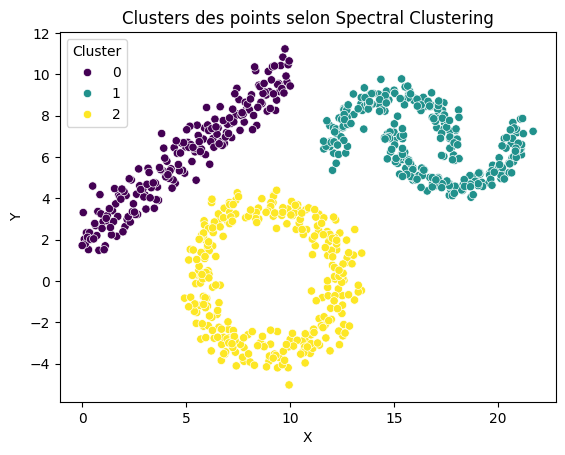

In [64]:
sns.scatterplot(data=df, x="X", y="Y", hue="Cluster", palette="viridis")
plt.title("Clusters des points selon Spectral Clustering")
plt.show()

On constate que les 3 clusters sont clairement identifiés.


## Gaussian Mixture


In [65]:
gaussian = GaussianMixture(n_components=n_clusters)
gaussian.fit(df)

df["Cluster"] = gaussian.predict(df)

df.head()

,X,Y,Cluster
0,6.776043,2.161305,1
1,7.537688,8.778988,2
2,17.667300,6.899375,0
3,17.049413,7.418676,0
4,6.589132,2.978855,1


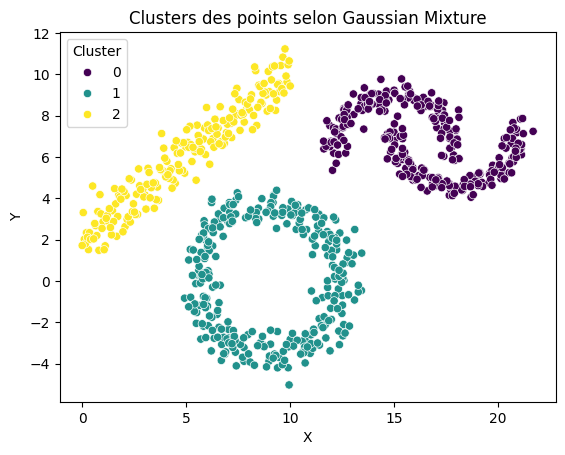

In [66]:
sns.scatterplot(data=df, x="X", y="Y", hue="Cluster", palette="viridis")
plt.title("Clusters des points selon Gaussian Mixture")
plt.show()

On constate que les 3 clusters sont clairement identifiés.


## Conclusion


On constate que les modèles Spectral Clustering et Gaussian Mixtures ont mieux identifier (d'un point de vue graphique) les trois clusters, contrairement à K-Means.


## Bonus


On peut aussi afficher les clusters issus de plusieurs modèles de scikit-learn :
- MiniBatch KMeans, 
- Affinity Propagation,
- MeanShift, Spectral 
- Clustering, 
- Ward, 
- Agglomerative Clustering,
- DBSCAN, 
- HDBSCAN, 
- OPTICS, 
- BIRCH, 
- Gaussian Mixture.


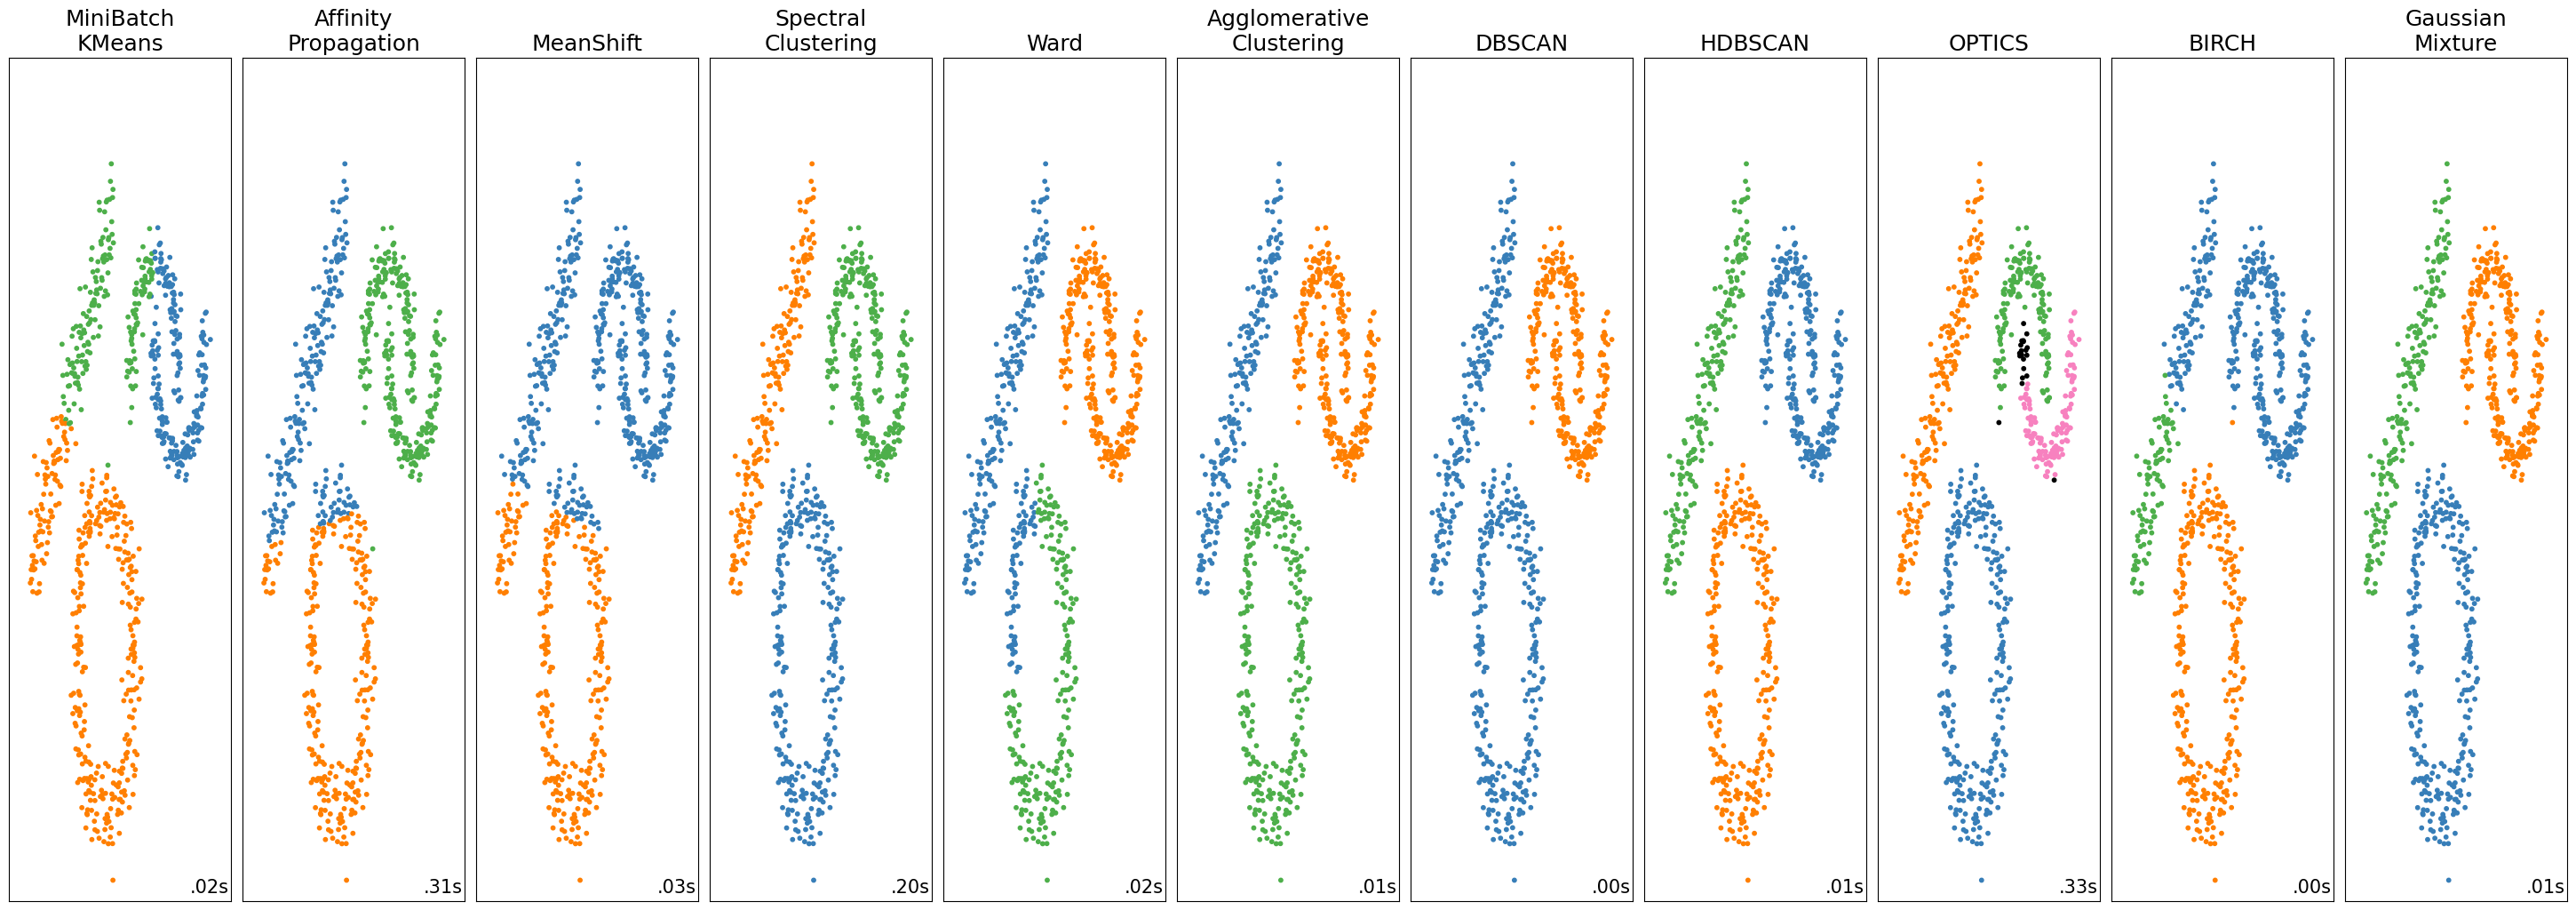

In [67]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import pandas as pd

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(30, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)


plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

# Load your dataset from a CSV file
data = pd.read_csv("../../data/exam_data.csv", delimiter=",", decimal=".")

# Assuming the CSV has two columns for the features
X = data.iloc[:, :2].values

# Create a dummy target variable (if needed)
y = None

datasets = [
    (
        (X, y),
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 3,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    hdbscan = cluster.HDBSCAN(
        min_samples=params["hdbscan_min_samples"],
        min_cluster_size=params["hdbscan_min_cluster_size"],
        allow_single_cluster=params["allow_single_cluster"],
    )
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"],
        covariance_type="full",
        random_state=params["random_state"],
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("HDBSCAN", hdbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()